# Notebook for Finding t0 with Bi
This notebook follows similar steps as Fast_Analysis.ipynb but is specifically meant for analyzing Bi scans

## Global Variable Usage
The package gued relies on a few global variables which should be optimized for each experiment. The global variables are stored in gued_globals.py and follow standard formatting of all caps (i.e., CENTER_GUESS = (470, 450)).   

__Note:__ if you change the global variables, you have to restart the kernel for the changes to be applied.

In [1]:
%%writefile gued_globals.py
"""Python file for establishing global variables that change from experiment to experiment. Each global variable should be notated with 
all caps."""

### Global Variables for demo data set
# Variable for reading files
PATH_SEPARATOR = '/' # input how folders are separator in the file path
SEPARATORS = '_' # underscore or dash usually, based on how the files are named

# Variables for Center Finding Algorithm
CENTER_GUESS = (465, 475)
RADIUS_GUESS = 35
DISK_RADIUS = 3 
THRESHOLD = 1000

# Variable for Generating Background
CORNER_RADIUS = 20
CHECK_NUMBER = 50

# Variables for Masking
MASK_CENTER = [525, 515] # x, y position for mask
MASK_RADIUS = 50 # radius for mask
#ADDED_MASK = [[546, 470, 40]]
ADDED_MASK = []

# Used throughout code as the threshold for cutting out date. This is the default value but other values can be set for the functions using this variable
STD_FACTOR = 3

# Specifies the maximum number of workers to be used when running concurrent.futures
MAX_PROCESSORS = 8

# Adjust figure size 
FIGSIZE = (10,4)

# Path for Theory Package
PATH_DCS = '/packages/dcs_repositiory/3.7MeV/'


Overwriting gued_globals.py


## Import Packages

In [17]:
import numpy as np
import glob 
import matplotlib.pyplot as plt
from datetime import date
import scipy.optimize
import scipy

#new code
import gued 

# interactive plotting
%matplotlib widget

## Import all images

/sdf/data/lcls/ds/ued_testfac/data/ueduu101/Cyclopentadiene/20231103/Run/20231103_1132/*/ANDOR1_*.tif
Number of files being loaded:  104
Loading diffraction signal


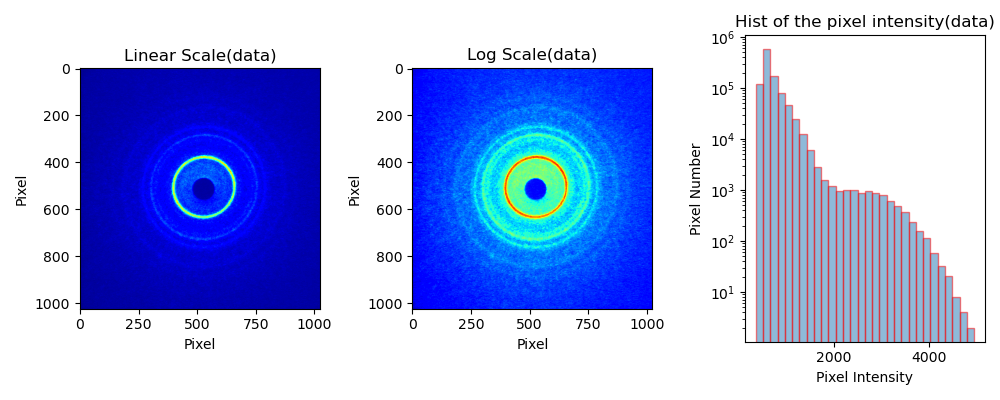

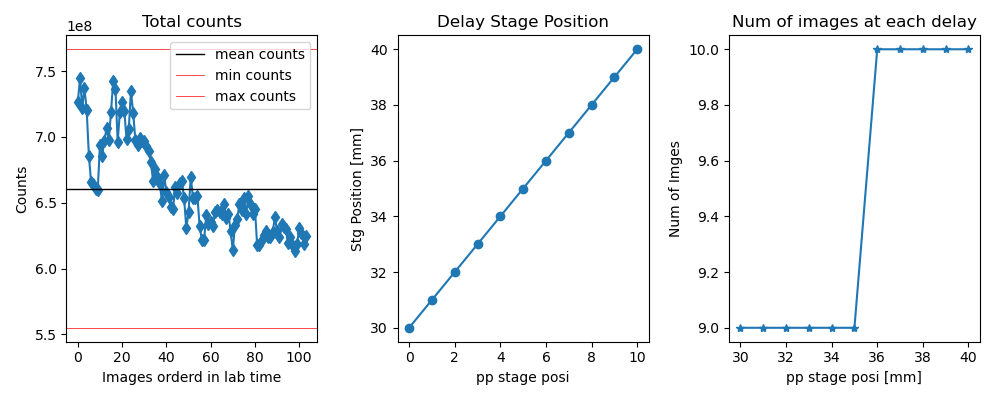

Image number read:  104
Stage positions:  11
104


In [3]:
# Using glob and * place holders to read in all file names from the specified path
data_path = '/sdf/data/lcls/ds/ued_testfac/data/ueduu101/Cyclopentadiene/20231103/Run/20231103_1132/'

run_path = "*/ANDOR1_*.tif"

full_path = data_path + run_path
print(full_path)

files = glob.glob(full_path) 
print("Number of files being loaded: ", len(files))


print('Loading diffraction signal');
data_array, stage_positions, file_order, counts = gued.get_image_details(files[:], sort=True, plot=True, filter_data=False)

counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position


print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage))

## Average Based on Stage Positions

In [4]:
stage_len = len(uni_stage);               #  Number of delays
ave_data = np.ones((stage_len,1024,1024));  # temporary array to be filled in


if stage_len>20:
    prt_count = 5
else:
    prt_count = 1  
for i in range(stage_len):
    if i%prt_count == 0:
        print(f'Averaging data at stage posi # {uni_stage[i]}') # Obtain a sub array to save the data in one delay
    stage_data = data_array[np.where(stage_positions==uni_stage[i])[0]]
    ave_data[i] = np.nanmean(stage_data,axis=0) #assign values to array

data_array = ave_data # renaming for ease and continuity
print(data_array.shape)

Averaging data at stage posi # 30.0
Averaging data at stage posi # 31.0
Averaging data at stage posi # 32.0
Averaging data at stage posi # 33.0
Averaging data at stage posi # 34.0
Averaging data at stage posi # 35.0
Averaging data at stage posi # 36.0
Averaging data at stage posi # 37.0
Averaging data at stage posi # 38.0
Averaging data at stage posi # 39.0
Averaging data at stage posi # 40.0
(11, 1024, 1024)


## Subtract Background Based on Corners

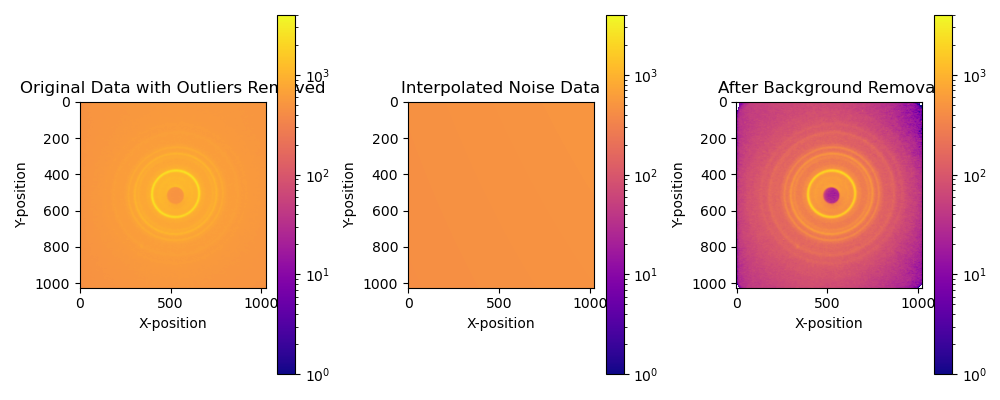

In [5]:
data_array = gued.remove_background_pool(data_array, remove_noise=True, plot=True)

## Remove Hot Pixels

Removing hot pixels from all data


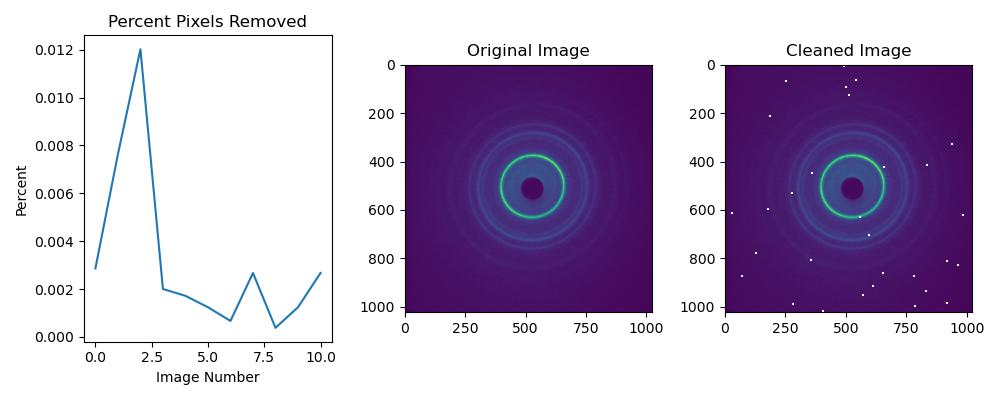

In [6]:
data_array = gued.remove_xrays_pool(data_array, plot=True, return_pct=False)

## Mask Beam Block and Artifacts


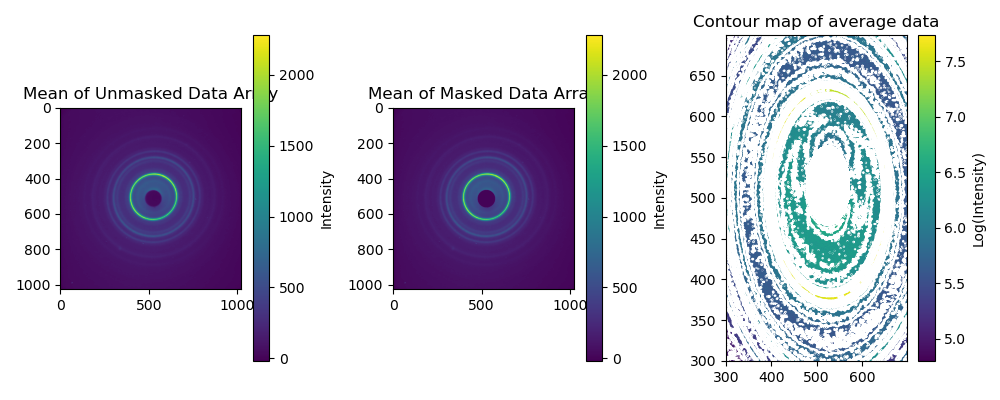

In [7]:
# Apply Mask
data_array = gued.apply_mask(data_array, fill_value=0.0, plot=True, print_vals=False)

## Find Centers

First, adjust global variables using the `Set_up_Globals.ipynb` notebook to get centers accurately. Should not see center jumps more than one or two pixels. If this is happening you probably need to adjust global values

### Test with One Image

In [8]:
# First, check the threshold value being calculated by the code, a good value is usually close to 100
from skimage.filters import threshold_otsu
for data in data_array:
    print(threshold_otsu(data))

351.91986747911756
335.7350079725935
360.9441876613324
347.420593039529
350.72558504482316
330.72151628278664
317.48785697912547
315.5345639754298
355.3275211045732
347.81612200508977
360.31892045548466


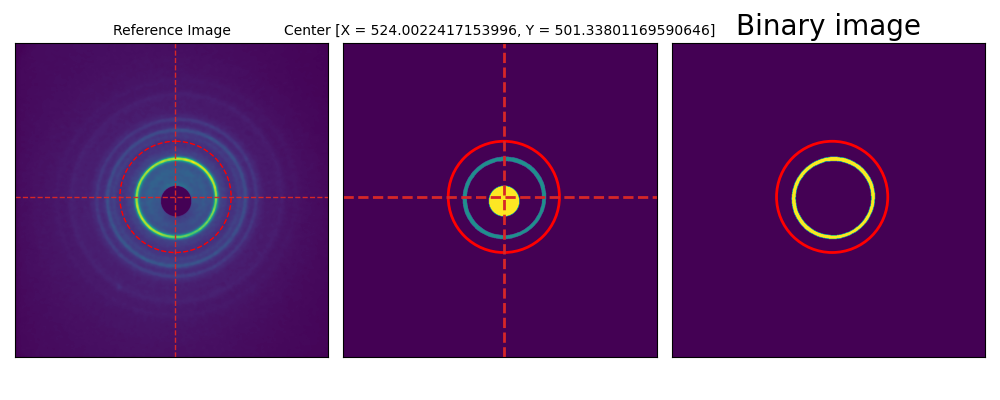

In [9]:
# Check your global variables by testing the center finding algorithm on one image 

test_x, test_y, _, _ = gued.finding_center_alg(data_array[0], plot=True)

### Find all Centers

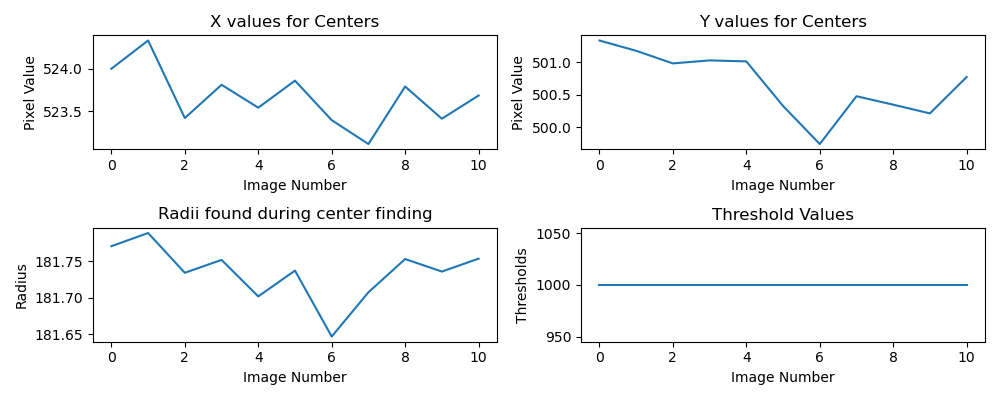

In [10]:
center_x, center_y = gued.find_center_pool(data_array, plot=True)
center = list(zip(center_x, center_y))
center = np.mean(center, axis=0)

## Reapply mask with nan values

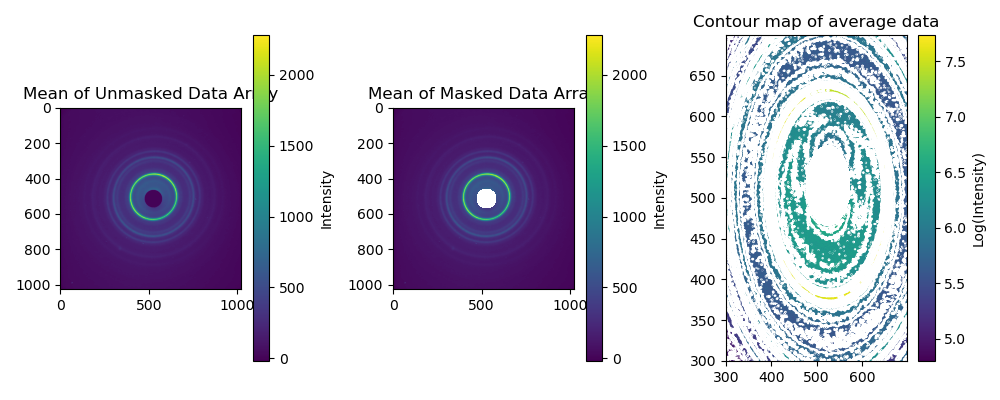

In [11]:
# Apply Mask
data_array = gued.apply_mask(data_array, fill_value=np.nan, plot=True, print_vals=False)

## Get Azimuthal Average and Normalize

Using average center
Calculating azimuthal average for all data
maximum value previously: 450 -- length of array: 450


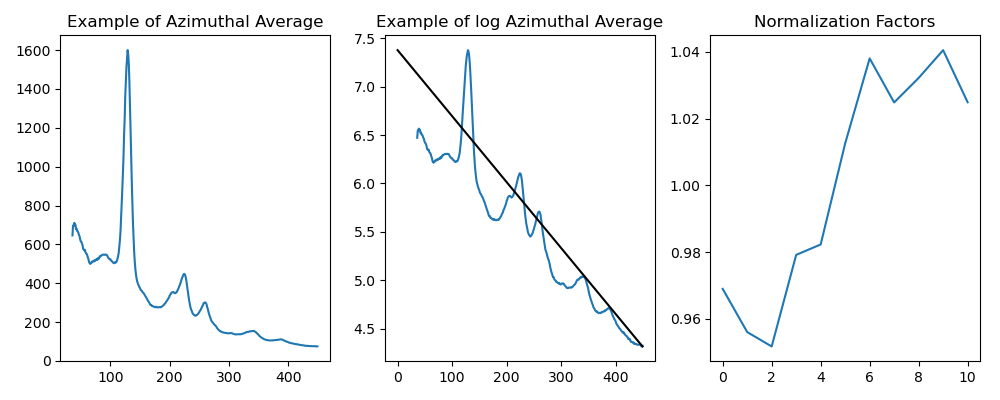

In [12]:
norm_data, norm_std = gued.get_azimuthal_average_pool(data_array, center, normalize=True, plot=True)

## Plot Pump Probe Lineouts

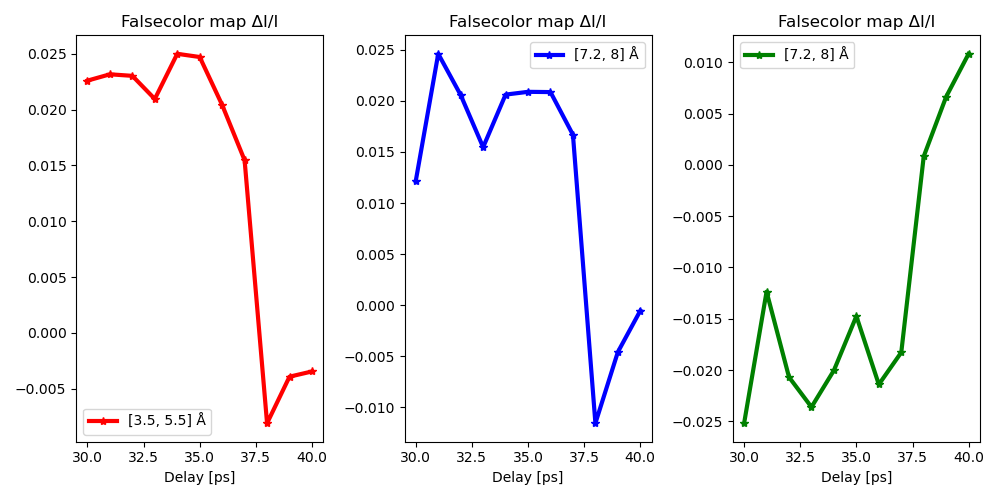

In [13]:
# (3) Plot the figure: Plot the time-dependent signal
angs = '\u00C5' # angstrom sign
s_cali = 0.0248 # S calibration in experiment
#s_cali = 0.02134
posi_0 = 156.3
s = np.arange(0,len(norm_data[0]))*s_cali # The Q axis

if stage_len<5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 4
norm_ref = np.nanmean(norm_data[-N_ref:],axis=0)         # Reference signal before T0

dI_I_norm = (norm_data-norm_ref)/norm_ref; # Calculate the percentage difference signal

RoI_1 = [3.5, 5.5]
RoI_2 = [7.2, 8]
RoI_3 = [8, 9]
#print(round(RoI_1[0]/s_cali))
Inte_1 = dI_I_norm[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1)
Inte_2 = dI_I_norm[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1)
Inte_3 = dI_I_norm[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].mean(axis=1)

# Plot a figure of the time-depdendent signal of scattering percentage difference.
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.plot(uni_stage,Inte_1,'-*', color='r', linewidth=3,label=str(RoI_1)+' '+angs)
plt.legend()
plt.xlabel('Integrated Yield [arb.]')
plt.xlabel('Delay [ps]')
plt.title('Falsecolor map ΔI/I')

plt.subplot(1,3,2)
plt.plot(uni_stage,Inte_2,'-*', color="b", linewidth=3,label=str(RoI_2)+' '+angs)
plt.legend()
plt.xlabel('Integrated Yield [arb.]')
plt.xlabel('Delay [ps]')
plt.title('Falsecolor map ΔI/I')

plt.subplot(1,3,3)
plt.plot(uni_stage,Inte_3,'-*',color="green", linewidth=3,label=str(RoI_2)+' '+angs)
plt.legend()
plt.xlabel('Integrated Yield [arb.]')
plt.xlabel('Delay [ps]')
plt.title('Falsecolor map ΔI/I')
plt.tight_layout()
plt.show()


## Fit Rise Time and t0 Position

Fit parameters: 
t_0 = 37.368 ps +/- 0.08 ps
sigma = -1.242 ps +/- 0.21 ps
offset = 0.038


Fit parameters: 
t_0 = 37.174 ps +/- 0.11 ps
sigma = 1.785 ps +/- 0.37 ps


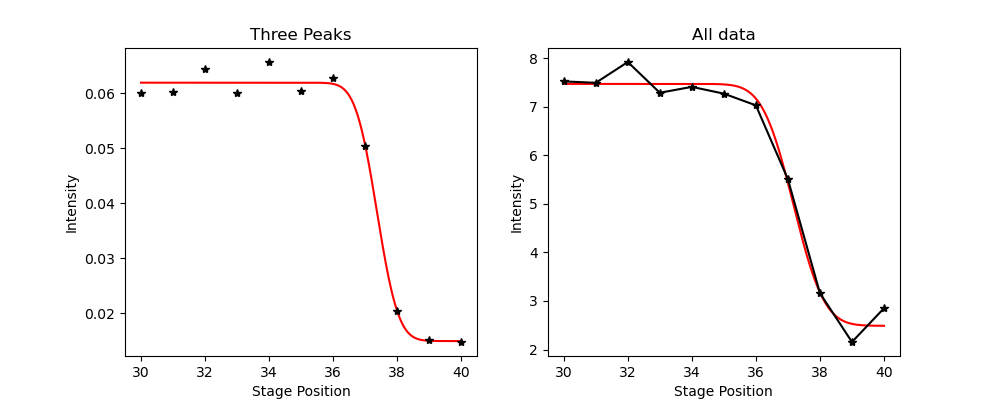

In [29]:
# Fit the curve to the data

three_peaks = np.abs(Inte_1) + np.abs(Inte_2) + np.abs(Inte_3) #combination of multiple peaks for more data
all_data = np.nansum(np.abs(dI_I_norm), axis=1)
#all_azimuthal = gued.normalize_to_range(all_azimuthal, min_val=0, max_val=1)


# Define the error function using scipy.special.erf
def error_function(t, a, t0, sigma, offset):
    return a * scipy.special.erf((t-t0)/(sigma/(np.sqrt(2*np.log(2))))*np.sqrt(2)) + offset


# Define bounds for the parameters [amplitude, t0, sigma, offset]
bounds = ([-1, -0.5, 0, -0.001], [1, 1, 1.5, 0.1])  # lower bounds, upper bounds
guesses = [0.01, 37.5, 0.5, 0.0]

# Fit 3 peaks of data
popt, pcov = scipy.optimize.curve_fit(error_function, uni_stage, three_peaks[:], p0=guesses)

stage_new = np.linspace(uni_stage[0], uni_stage[-1], 1000)
## error func fit
A, t0, sigma, offset = popt
#A1, t1, sigma1, offset1 = popt_all
print("Fit parameters: ")
print("=====================================================")

print(f"t_0 = {popt[1]:.3f} ps +/- {np.sqrt(pcov[1,1]):.2f} ps")
print(f"sigma = {popt[2]:.3f} ps +/- {np.sqrt(pcov[2,2]):.2f} ps")
print(f"offset = {popt[3]:.3f}")

print("\n")
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(stage_new, error_function(stage_new, A, t0, sigma, offset) ,color='red', label="fit")
plt.plot(uni_stage, three_peaks, "*", color='black')
#plt.xlim(-1,2)
#plt.xlim(-1, 5)
plt.xlabel("Stage Position")
plt.ylabel("Intensity")
plt.title("Three Peaks")
#plt.legend()

# Define bounds for the parameters [amplitude, t0, sigma, offset]
bounds = ([-4, -0.5, 0, -4], [5, 1, 2, 5])  # lower bounds, upper bounds
guesses = [0.01, 37.5, 0.5, 4]


# Fit the curve to all dI/I data
popt, pcov = scipy.optimize.curve_fit(error_function, uni_stage, all_data[:], p0=guesses)

stage_new = np.linspace(uni_stage[0], uni_stage[-1], 1000)
## error func fit
A, t0, sigma, offset = popt
#A1, t1, sigma1, offset1 = popt_all
print("Fit parameters: ")
print("=====================================================")

print(f"t_0 = {popt[1]:.3f} ps +/- {np.sqrt(pcov[1,1]):.2f} ps")
print(f"sigma = {popt[2]:.3f} ps +/- {np.sqrt(pcov[2,2]):.2f} ps")

plt.subplot(1,2,2)
plt.plot(stage_new, error_function(stage_new, A, t0, sigma, offset) ,color='red', label="fit")
plt.plot(uni_stage, all_data, "-*", color='black')
#plt.xlim(-1,2)
#plt.xlim(-5, 5)
plt.xlabel("Stage Position")
plt.ylabel("Intensity")
plt.title("All data")
#plt.legend()
plt.show()

